In [1]:
# Import modules used for the decision tree classifier & plot
from sklearn import preprocessing, neighbors, naive_bayes, neural_network, svm, tree
from sklearn.metrics import confusion_matrix,  roc_curve, auc
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, VotingClassifier
from sklearn.decomposition import PCA
from scipy import interp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import HTML, display
import tabulate

In [2]:
# Read the csv file, dropping the unnamed id column
# Show the first 5 rows after modification for review
dataset = pd.read_csv('PD_remove_std_PSF.csv')
dataset.drop(['Gender'], 1, inplace=True)
dataset.head()

,Unnamed: 0,Status,MDVP:Jitter(%),MDVP:Jitter(Abs),Jitter:PPQ5,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA,RPDE,DFA,PPE
0,0,1,-0.054993,0.037705,0.078201,0.062894,-0.201283,-0.233889,-0.190826,-0.228931,-0.208934,-0.190677,0.605835,0.256144,0.627644
1,1,1,-0.142570,-0.027844,-0.023255,-0.083360,-0.286750,-0.273123,-0.499987,-0.162993,0.194112,-0.499839,0.368415,-0.080433,0.121620
2,2,1,-0.214916,-0.089022,-0.029223,-0.035742,0.734660,0.760052,0.741128,0.876535,0.659075,0.741133,0.733609,-0.349839,0.617950
3,3,1,0.710353,1.256904,0.907750,0.899601,-0.301887,-0.207732,-0.466431,-0.464316,-0.316846,-0.466432,0.753631,1.382279,-1.980560
4,4,1,1.152045,1.178246,0.663063,1.079867,-0.264860,-0.286201,-0.236462,-0.291184,-0.076256,-0.236313,0.300123,1.398068,-2.472989


In [3]:
# Displaying the shape and datatype for each attribute
print(dataset.shape)
dataset.dtypes

(756, 15)


Unnamed: 0            int64
Status                int64
MDVP:Jitter(%)      float64
MDVP:Jitter(Abs)    float64
Jitter:PPQ5         float64
Jitter:DDP          float64
MDVP:Shimmer        float64
MDVP:Shimmer(dB)    float64
Shimmer:APQ3        float64
Shimmer:APQ5        float64
Shimmer:APQ11       float64
Shimmer:DDA         float64
RPDE                float64
DFA                 float64
PPE                 float64
dtype: object

In [4]:
# Dispalying the descriptive statistics describe each attribute
dataset.describe()

,Unnamed: 0,Status,MDVP:Jitter(%),MDVP:Jitter(Abs),Jitter:PPQ5,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA,RPDE,DFA,PPE
count,756.000000,756.000000,7.560000e+02,7.560000e+02,7.560000e+02,7.560000e+02,7.560000e+02,7.560000e+02,7.560000e+02,7.560000e+02,7.560000e+02,7.560000e+02,7.560000e+02,7.560000e+02,7.560000e+02
mean,377.500000,0.746032,6.109164e-17,2.819614e-17,8.693810e-17,6.579099e-17,5.639228e-17,-7.988906e-17,1.644775e-16,2.349678e-17,-4.699357e-17,7.049035e-18,-1.879743e-17,-1.381611e-15,9.234236e-16
std,218.382692,0.435568,1.000662e+00,1.000662e+00,1.000662e+00,1.000662e+00,1.000662e+00,1.000662e+00,1.000662e+00,1.000662e+00,1.000662e+00,1.000662e+00,1.000662e+00,1.000662e+00,1.000662e+00
min,0.000000,0.000000,-8.051086e-01,-7.008068e-01,-6.618294e-01,-6.003491e-01,-1.418546e+00,-1.437080e+00,-1.388095e+00,-1.363865e+00,-1.621513e+00,-1.388249e+00,-2.437232e+00,-2.252183e+00,-4.165544e+00
25%,188.750000,0.000000,-5.157240e-01,-4.997919e-01,-4.708539e-01,-4.642993e-01,-7.306771e-01,-7.524381e-01,-7.396864e-01,-7.087267e-01,-7.195235e-01,-7.395394e-01,-7.464066e-01,-7.658960e-01,9.781373e-02
50%,377.500000,1.000000,-3.158201e-01,-3.140715e-01,-3.037504e-01,-3.316506e-01,-2.734761e-01,-2.718154e-01,-2.861247e-01,-2.751604e-01,-2.306051e-01,-2.860502e-01,-3.423773e-02,1.594017e-03,3.745726e-01
75%,566.250000,1.000000,7.446834e-02,6.938647e-02,5.582062e-02,4.673808e-02,4.209129e-01,4.971809e-01,4.603787e-01,4.364299e-01,4.722936e-01,4.604566e-01,7.095471e-01,7.832576e-01,5.203332e-01
max,755.000000,1.000000,9.681276e+00,1.047737e+01,1.024168e+01,1.065778e+01,4.274199e+00,3.943278e+00,4.301169e+00,5.832526e+00,6.549389e+00,4.301339e+00,2.782440e+00,2.184898e+00,9.538615e-01


<AxesSubplot:>

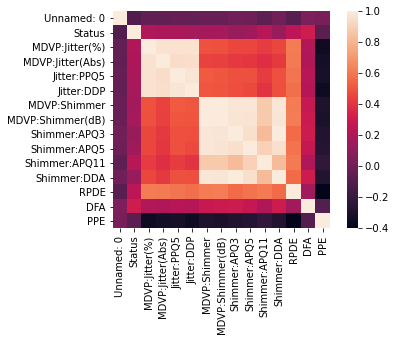

In [5]:
# Heatmap visulisation for each attribute coefficient correlation.
import seaborn as sb
corr_map=dataset.corr()
sb.heatmap(corr_map,square=True)

<AxesSubplot:>

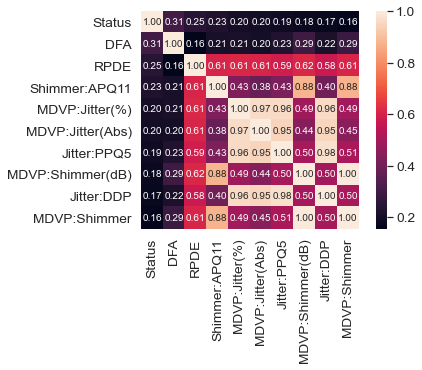

In [6]:
# Now visualise the heat map with correlation coefficient values for pair of attributes.
import matplotlib.pyplot as plt
import numpy as np

# K value means how many features required to see in heat map
k=10

# finding the columns which related to output attribute and we are arranging from top coefficient correlation value to downwards.
cols=corr_map.nlargest(k,'Status')['Status'].index

# correlation coefficient values
coff_values=np.corrcoef(dataset[cols].values.T)
sb.set(font_scale=1.25)
sb.heatmap(coff_values,cbar=True,annot=True,square=True,fmt='.2f',annot_kws={'size': 10},yticklabels=cols.values,xticklabels=cols.values)

In [7]:
# correlation coefficient values in each attributes.
correlation_values=dataset.corr()['Status']
correlation_values.abs().sort_values(ascending=False)

Status              1.000000
DFA                 0.306070
RPDE                0.247444
Shimmer:APQ11       0.227427
MDVP:Jitter(%)      0.204228
MDVP:Jitter(Abs)    0.195651
Jitter:PPQ5         0.189395
MDVP:Shimmer(dB)    0.176239
Jitter:DDP          0.173278
MDVP:Shimmer        0.161697
Shimmer:APQ5        0.149086
Shimmer:DDA         0.128256
Shimmer:APQ3        0.128252
Unnamed: 0          0.111660
PPE                 0.072939
Name: Status, dtype: float64

In [8]:
# split the dataset into input and output attribute.

y=dataset['Status']
cols=['Unnamed: 0','Status']
x=dataset.drop(cols,axis=1)

In [9]:
# Splitting the dataset into trianing and test set

train_size=0.80
test_size=0.20
seed=5

from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,train_size=train_size,test_size=test_size,random_state=seed)

decision_tree : 0.745191 (0.076393)


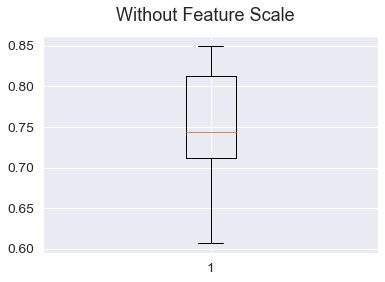

In [10]:
n_neighbors=5
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

# keeping all models in one list
models=[]
models.append(("decision_tree",DecisionTreeClassifier()))

# Evaluating Each model
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
names=[]
predictions=[]
error='accuracy'
for name,model in models:
    fold=KFold(n_splits=10)
    result=cross_val_score(model,x_train,y_train,cv=fold,scoring=error)
    predictions.append(result)
    names.append(name)
    msg="%s : %f (%f)"%(name,result.mean(),result.std())
    print(msg)
    

# Visualizing the Model accuracy
fig=plt.figure()
fig.suptitle("Without Feature Scale")
plt.boxplot(predictions)
plt.show()

decision_tree : 0.750109 (0.072722)


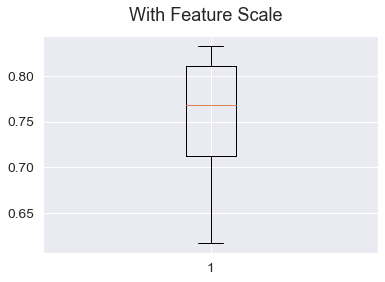

In [11]:
# Spot Checking and Comparing Algorithms With StandardScaler Scaler
from sklearn.pipeline import Pipeline
from sklearn. preprocessing import StandardScaler
pipelines=[]
pipelines.append(('scaled DecisionTree',Pipeline([('scaler',StandardScaler()),('decision',DecisionTreeClassifier())])))

# Evaluating Each model
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
names=[]
predictions=[]
for name,model in models:
    fold=KFold(n_splits=10)
    result=cross_val_score(model,x_train,y_train,cv=fold,scoring=error)
    predictions.append(result)
    names.append(name)
    msg="%s : %f (%f)"%(name,result.mean(),result.std())
    print(msg)
    

# Visualizing the Model accuracy
fig=plt.figure()
fig.suptitle("With Feature Scale")
plt.boxplot(predictions)
plt.show()

In [13]:
# Decision Tree Tunning Algorithms
import numpy as np
from sklearn.model_selection import GridSearchCV
scaler=StandardScaler().fit(x_train)
rescaledx=scaler.transform(x_train)
param_grid=dict()
model=DecisionTreeClassifier()
fold=KFold(n_splits=10)
grid=GridSearchCV(estimator=model,param_grid=param_grid,scoring=error,cv=fold)
grid_result=grid.fit(rescaledx,y_train)

print("Best: %f using %s "%(grid_result.best_score_,grid_result.best_params_))

Best: 0.756721 using {} 


In [18]:
# Finalize the model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
scaler=StandardScaler().fit(x_train)
scaler_x=scaler.transform(x_train)
model.fit(scaler_x,y_train)

#Transform the validation test set data
scaledx_test=scaler.transform(x_test)
y_pred=model.predict(scaledx_test)
y_predtrain=model.predict(scaler_x)

In [19]:
# Calculate accuracy
accuracy_mean=accuracy_score(y_train,y_predtrain)
accuracy_matric=confusion_matrix(y_train,y_predtrain)
print("train set",accuracy_mean)
print("train set matrix",accuracy_matric)

accuracy_mean=accuracy_score(y_test,y_pred)
accuracy_matric=confusion_matrix(y_test,y_pred)
print("test set",accuracy_mean)
print("test set matrix",accuracy_matric)

train set 1.0
train set matrix [[148   0]
 [  0 456]]
test set 0.6776315789473685
test set matrix [[18 26]
 [23 85]]


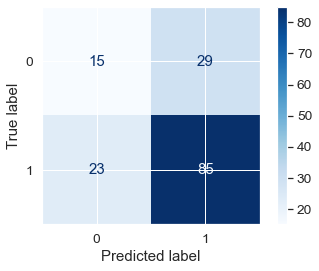

In [25]:
# performace test from Nadia
import csv
import matplotlib.pyplot as plt
import os
import secrets  # to generate jpg name

def performance_report(model, X, y, X_test, y_test, y_pred, model_label):

  # classification accuracy
  try:
    from sklearn.metrics import accuracy_score
    accuracy = accuracy_score(y_test, y_pred)
  except:
    accuracy = "NA"

  # confusion matrix
  from sklearn.metrics import confusion_matrix
  from sklearn.metrics import plot_confusion_matrix

  try:
    conf = confusion_matrix(y_test, y_pred)
    TP = conf[1][1]
    TN = conf[0][0]
    FP = conf[0][1]
    FN = conf[1][0]

    disp = plot_confusion_matrix(model, X_test, y_test, cmap=plt.cm.Blues, values_format='.0f')
    title = secrets.token_hex(4)
    plt.savefig(title, format="jpg")

    path1 = os.path.abspath(title+".jpg")
  except:
    TP = TN = FP = FN = path1 = ""

  # k-fold cross validation
  from sklearn import model_selection
  try:
    kfold = model_selection.KFold(n_splits=6, shuffle=True)
    KCV = model_selection.cross_val_score(model, X, y, cv=kfold, scoring='accuracy').mean()
  except:
    KCV = ""

  # log loss (closer to 0 is better)
  try:
    logloss = model_selection.cross_val_score(model, X, y, cv=kfold, scoring='neg_log_loss').mean()
  except:
    logloss = ""

  # AUC (1 is perfect predictions, 0.5 is as good as random)
  try:
    AUC = model_selection.cross_val_score(model, X, y, cv=kfold, scoring='roc_auc').mean()
  except:
    AUC = ""

  # precision recall curve
  from sklearn.metrics import plot_precision_recall_curve
  from sklearn.metrics import average_precision_score

  try:
    y_score = model.decision_function(X_test)
    average_precision = average_precision_score(y_test, y_score)

    disp = plot_precision_recall_curve(model, X_test, y_test)
    title = secrets.token_hex(4)  
    plt.savefig(title, format="jpg")

    path2 = os.path.abspath(title+".jpg")
  except:
    average_precision = path2 = ""

  # appending metrics to csv file
  with open('metrics.csv', 'a', newline='') as file:
    writer = csv.writer(file)
    if os.stat("metrics.csv").st_size == 0:
      writer.writerow(["Model label", "Accuracy score", "TP", "TN", "FP", "FN", "Confusion matrix file","KCV", "Log-loss", "AUC", "Average precision", "Precision-recall file"])
    writer.writerow([model_label, accuracy, TP, TN, FP, FN, path1, KCV, logloss, AUC, average_precision, path2])
    
    
performance_report(model, x, y, x_test, y_test, y_pred, 'decision_tree_classifier')